In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np

from sklearn.datasets import make_moons

from tqdm.auto import trange

from loss import fff_loss
from models import ResNet, SkipConnection

device = "cpu"

c:\Users\Fritz\anaconda3\envs\analyzing_invs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'ResNet' from 'models' (c:\Users\Fritz\uni\Masterarbeit\fff\models.py)

# ResNet

In [28]:
def train_fff_with_resnet(resnet_params, n_steps=10000, batchsize=1024, lr=2e-4, beta=100.):
  rn_encoder = ResNet(**resnet_params)
  rn_decoder = ResNet(**resnet_params)
  optimizer = torch.optim.Adam(params=[*rn_encoder.parameters(), *rn_decoder.parameters()], lr=lr)
  
  loss_history = []
  
  for n in trange(n_steps):
    optimizer.zero_grad()
    batch, _ = make_moons(batchsize, noise=0.1)
    x = torch.from_numpy(batch).float().to(device)

    loss = fff_loss(x=x, encode=rn_encoder, decode=rn_decoder, beta=beta)
    loss.mean().backward()
    optimizer.step()

    loss_history.append(loss.mean().detach().numpy())
  return rn_encoder, rn_decoder, loss_history

In [29]:
def rn_hyper_test(param_name, param_list, resnet_config, train_config, train_param=False):
    fig, axs = plt.subplots(2, len(param_list), figsize=(10, 6))

    for i, p in enumerate(param_list):
        if not train_param: resnet_config[param_name] = p
        else: train_config[param_name] = p
        _, decoder, loss_history = train_fff_with_resnet(resnet_params=resnet_config, **train_config)
        axs[0][i].plot(loss_history)
        axs[0][i].set_yscale("log")
        
        batch, _ = make_moons(train_config["batchsize"], noise=0.1)
        x = torch.from_numpy(batch).float().to(device)
        z = torch.randn_like(torch.Tensor(x))
        x_rec = decoder(z)
        axs[1][i].scatter(x_rec.detach()[:,0], x_rec.detach()[:,1], s=4, alpha=.7, label="FFF")
        axs[1][i].scatter(x.detach()[:,0], x.detach()[:,1], s=4, alpha=.7, label="True")
        
    plt.legend()
    plt.show()

100%|██████████| 10000/10000 [12:00<00:00, 13.89it/s]


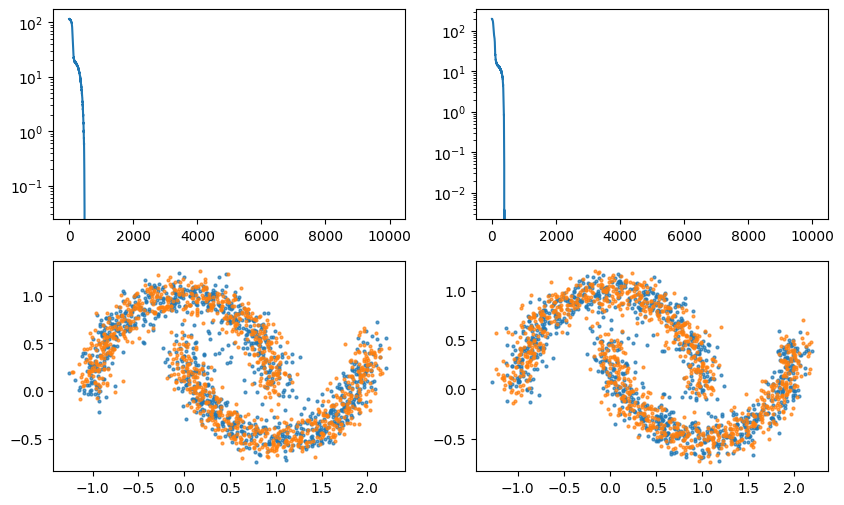

In [31]:
resnet_config = {"n_dim": 2,
                 "hidden_dim": 128,
                 "n_blocks": 1,
                 "output_dim": 2}

train_config = {"n_steps": 10000,
                "batchsize": 1024,
                "lr": 2e-4,
                "beta": 100.}

#fff, loss_history = train_fff_with_resnet(resnet_params=resnet_config, **train_config)
rn_hyper_test("hidden_dim", (64, 128), resnet_config, train_config)


# SkipConnection

In [32]:
def train_fff_with_skipconnection(dim=2, latent_dim=2, hidden_dim=128, n_steps=10000, batch_size=1024, noise=0.1, beta=100):
  sc_encoder = SkipConnection(dim, latent_dim, hidden_dim)
  sc_decoder = SkipConnection(latent_dim, dim, hidden_dim)
  optim = torch.optim.Adam([*sc_encoder.parameters(), *sc_decoder.parameters()], lr=2e-4)

  loss_history = []
  with trange(n_steps) as pbar:
      for step in pbar:
          optim.zero_grad()
          batch, _ = make_moons(batch_size, noise=noise)
          x = torch.from_numpy(batch).float().to(device)
          
          loss = fff_loss(x=x, encode=sc_encoder, decode=sc_decoder, beta=beta)
          loss.mean().backward()
          optim.step()
          
          loss_history.append(loss.mean().detach().numpy())
  return sc_encoder, sc_decoder, loss_history

In [33]:
sc_encoder, sc_decoder, sc_loss = train_fff_with_skipconnection()

100%|██████████| 10000/10000 [13:26<00:00, 12.40it/s]


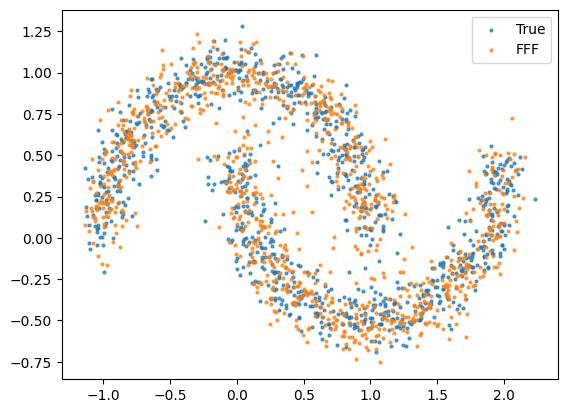

In [35]:
def sample(n_samples, decoder, latent_dim=2):
    z = torch.randn(n_samples, latent_dim, device=device)
    return decoder(z)

test_size = 1_000
test_batch, _ = make_moons(test_size, noise=0.1)

plot_kwargs = dict(
    s=4,
    alpha=.7
)

plt.scatter(*test_batch.T, label="True", **plot_kwargs)

with torch.no_grad():
    plt.scatter(*sample(test_size, sc_decoder).cpu().T, label="FFF", **plot_kwargs)
plt.legend()